# 01. EDA

In [1]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
DATA_PATH = Path("./data/raw/")

SLC_FILES = ["Users.csv", "Competitions.csv", "ForumMessages.csv", "Kernels.csv"]
MEDAL_MAP = {"": None, "3": "bronze", "2": "silver", "1": "gold"}

class CFG:
    # If True, the processed file is dumped
    save = True

In [3]:
files = [str(file_path).split("/")[-1] for file_path in DATA_PATH.glob("*.csv")]
files.sort()
print(f"All files:\n{files}")

All files:
['CompetitionTags.csv', 'Competitions.csv', 'DatasetTags.csv', 'DatasetTaskSubmissions.csv', 'DatasetTasks.csv', 'DatasetVersions.csv', 'DatasetVotes.csv', 'Datasets.csv', 'Datasources.csv', 'EpisodeAgents.csv', 'Episodes.csv', 'ForumMessageVotes.csv', 'ForumMessages.csv', 'ForumTopics.csv', 'Forums.csv', 'KernelLanguages.csv', 'KernelTags.csv', 'KernelVersionCompetitionSources.csv', 'KernelVersionDatasetSources.csv', 'KernelVersionKernelSources.csv', 'KernelVersions.csv', 'KernelVotes.csv', 'Kernels.csv', 'Organizations.csv', 'Submissions.csv', 'Tags.csv', 'TeamMemberships.csv', 'Teams.csv', 'UserAchievements.csv', 'UserFollowers.csv', 'UserOrganizations.csv', 'Users.csv']


## Preprocess Data

In [4]:
users = pl.read_csv(DATA_PATH / "Users.csv")
comps = pl.read_csv(DATA_PATH / files[1], schema_overrides={"UserRankMultiplier": pl.Float64})
forum_msg = pl.read_csv(DATA_PATH / "ForumMessages.csv")
kernels = pl.read_csv(DATA_PATH / "Kernels.csv")

### *Competitions*
Competitions contain information about competition titles, hosts, timelines, **evaluation algorithms**, prizes, etc.

* Community competitions are the majority, followed by Featured, Research, and Playground.
* The peak of the number of hosted competitions matches the outbreak of Covid-19.

> Simulation competitions aren't included. I think they might be stored in `Episodes`-related files.

In [5]:
comps = (
    comps
    .with_columns(
        pl.col("EnabledDate").str.to_datetime("%m/%d/%Y %H:%M:%S"),
        pl.col("DeadlineDate").str.to_datetime("%m/%d/%Y %H:%M:%S"),
    )
    .sort(pl.col("EnabledDate"), descending=False)
)
print(f"Shape {comps.shape} | Timeline {comps['EnabledDate'].min()} ~ {comps['EnabledDate'].max()}")

Shape (5691, 42) | Timeline 2000-01-01 00:00:00 ~ 2024-08-01 00:00:04


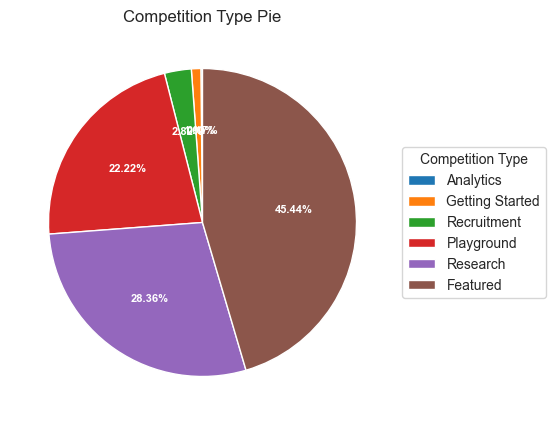

In [6]:
type_cnt = (
    comps
    .filter(pl.col("HostSegmentTitle") != "Community")["HostSegmentTitle"]
    .value_counts()
    .sort(pl.col("count"))
)
comp_types = type_cnt["HostSegmentTitle"].to_numpy()
data = type_cnt["count"].to_numpy()

fig, ax = plt.subplots(figsize=(6, 5))
wedges, texts, autotexts = ax.pie(
    data, 
    autopct=lambda pct: f"{pct:.2f}%",
    textprops=dict(color="w"),
    startangle=90
)
ax.legend(wedges, comp_types, title="Competition Type",
          loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Competition Type Pie")
plt.show()

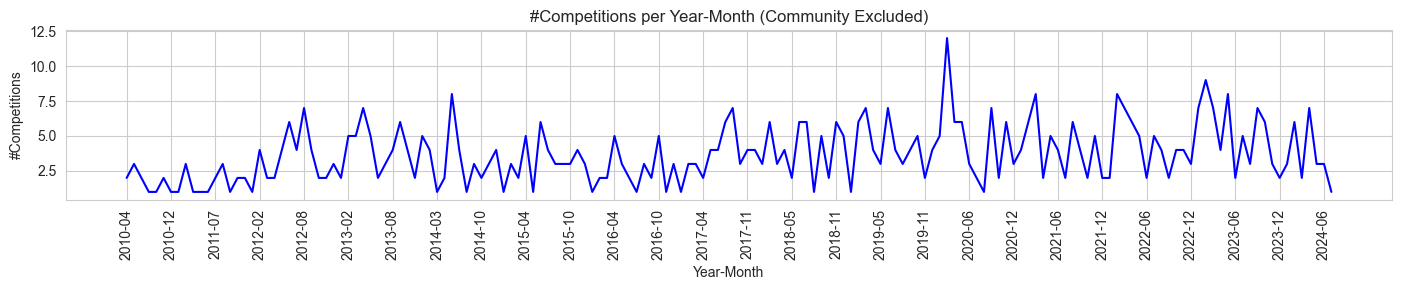

In [7]:
comps = (
    comps
    .filter(pl.col("HostSegmentTitle") != "Community")
    .with_columns(
        pl.col("EnabledDate").dt.strftime("%Y-%m").alias("start_year_month"),
    )
)
n_comps_per_month = (
    comps
    .group_by(["start_year_month"])
    .len()
    .sort(["start_year_month"], descending=False)
)
x = list(range(0, len(n_comps_per_month), 6))

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(n_comps_per_month["len"], "b-")
ax.set_title("#Competitions per Year-Month (Community Excluded)")
ax.set_xlabel("Year-Month")
ax.set_ylabel("#Competitions")
ax.set_xticks(x, n_comps_per_month["start_year_month"].to_numpy()[x], rotation=90)
plt.tight_layout()

## *Forums*

Forums contain all discussion posts, voting behaviors (e.g., A to B), etc.

In [8]:
[f for f in files if f.startswith("Forum")]

['ForumMessageVotes.csv', 'ForumMessages.csv', 'ForumTopics.csv', 'Forums.csv']

Seems related to datasets.

In [9]:
forum = pl.read_csv(DATA_PATH / "Forums.csv")
forum

Id,ParentForumId,Title
i64,str,str
991324,"""1023""","""gnomAD_H4"""
991310,"""1023""","""AI driven Car Dataset"""
991276,"""1023""","""beer_sao_paulo"""
40,"""8""","""ICDAR 2011 - Arabic Writer Ide…"
34,"""8""","""Deloitte/FIDE Chess Rating Cha…"
…,…,…
5953102,"""1023""","""Safety Helmet and Vest"""
5953045,"""1023""","""Luna_Data"""
5953039,"""1023""","""dataset_messidor_tif_ben_sam"""


Forum topics are associated with specific forums or kernels. But, there exist some with both `null`.

In [10]:
forum_topics = pl.read_csv(DATA_PATH / "ForumTopics.csv")
forum_topics

Id,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,Score,TotalMessages,TotalReplies
i64,i64,i64,i64,i64,str,str,str,bool,i64,i64,i64,i64
148165,16860,9245168,905429,831434,"""05/02/2020 13:32:33""","""06/28/2020 14:43:31""","""League of Legends - Win Predic…",false,0,15,5,5
147953,16860,9245178,853275,830305,"""05/02/2020 13:32:50""","""05/19/2020 04:16:13""","""kernelcdfefa0597""",false,0,1,2,2
150345,16860,9245344,849577,843305,"""05/02/2020 13:42:31""","""05/15/2020 22:56:44""","""Tissue Detect: Bounding Box Me…",false,0,10,4,4
147970,16860,9245486,830463,830463,"""05/02/2020 13:49:43""","""05/02/2020 15:54:12""","""Time Series Analysis: Corona D…",false,0,4,1,0
147985,16860,9246344,1304278,830551,"""05/02/2020 14:39:40""","""05/12/2021 14:28:15""","""Product quality with Keras""",false,0,12,5,5
…,…,…,…,…,…,…,…,…,…,…,…,…
522196,5576464,null,2989307,2935045,"""07/24/2024 23:33:07""","""09/14/2024 23:40:20""","""Llama-3.1-8B Quick Start""",false,0,6,13,12
521958,5576464,null,2938298,2933504,"""07/23/2024 18:05:04""","""07/28/2024 01:46:27""","""Transformers version""",false,0,3,7,6
523545,5576464,null,2955133,2943250,"""08/01/2024 13:12:36""","""08/10/2024 16:18:00""","""Correct file path for model?""",false,0,0,3,2


In [11]:
uniq_fid = forum_topics.filter(pl.col("KernelId").is_not_null())["ForumId"].unique()[0]
print(f"For those linked to kernels, the unique ForumId is {uniq_fid}.")

both_null = forum_topics.filter(pl.col("ForumId") == 16860)["KernelId"].is_null().sum()
print(f"There are {both_null} forum topics with both null.")

forum_topics = (
    forum_topics
    .with_columns(pl.col("ForumId").replace_strict({16860: None}, default=pl.col("ForumId")))
)

For those linked to kernels, the unique ForumId is 16860.
There are 1154 forum topics with both null.


Forum message votes contain voting dynamics of users, i.e., voting from user A to user B.

In [12]:
forum_msg_votes = pl.read_csv(DATA_PATH / "ForumMessageVotes.csv")
forum_msg_votes

Id,ForumMessageId,FromUserId,ToUserId,VoteDate
i64,i64,i64,i64,str
3372915,1,13067417,478,"""04/13/2023"""
183321,6,307512,638,"""04/06/2017"""
1024883,23,4256072,703,"""12/27/2019"""
1059375,28,417337,368,"""01/21/2020"""
4402419,28,6632177,368,"""07/16/2024"""
…,…,…,…,…
4510994,2996163,16402999,21309309,"""09/23/2024"""
4511052,2996175,14850461,8769433,"""09/23/2024"""
4511030,2996193,7274991,12598114,"""09/23/2024"""


The key information we want to use is the forum messages.

* `ForumTopicId`: Forum **topic** identifier (i.e., an independent discussion post).
    * To reconstruct the post url, we need the competition name.
        * e.g,. `https://www.kaggle.com/competitions/um-game-playing-strength-of-mcts-variants/discussion/532976`.
*  `Id`: Identifier of discussion reply.
    * One can reply to others' posted topics, shared kernels, etc.
    * It's marked as the suffix of the post url.
        * e.g., `https://www.kaggle.com/competitions/um-game-playing-strength-of-mcts-variants/discussion/532976#2992764`, `https://www.kaggle.com/code/noodl35/best-single-model-lgbm-no-blend/comments#2992016`

In [13]:
forum_msg = (
    forum_msg
    .with_columns(pl.col("PostDate").str.to_datetime("%m/%d/%Y %H:%M:%S"))
    .sort(pl.col("PostDate"), descending=False)
    .join(users.select(["Id", "UserName"]), how="left", left_on="PostUserId", right_on="Id")
    .drop(["PostUserId"])
)
forum_msg

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName
i64,i64,datetime[μs],str,str,str,str,str,str
159,1,2010-04-28 23:13:08,"""""","""Hi Bruce, I appreciate you des…","""""","""""","""""","""colingreen"""
157,1,2010-04-28 23:13:08,"""""","""<p>I'll briefly post a summary…","""""","""""","""""","""brucetabor"""
156,1,2010-04-28 23:13:08,"""""","""Hi Colin, ""Dividing the data …","""""","""""","""""","""brucetabor"""
154,1,2010-04-28 23:13:08,"""""","""Dividing the data into equally…","""""","""""","""""","""colingreen"""
152,1,2010-04-28 23:13:08,"""""","""Rajstennaj, I can't say I've…","""""","""""","""""","""brucetabor"""
…,…,…,…,…,…,…,…,…
2996246,535108,2024-09-23 08:50:56,"""2993850""","""<p>Absolutely, Text-to-image m…","""Absolutely, Text-to-image mode…","""""","""""","""devanggiri"""
2996251,535273,2024-09-23 08:52:49,"""2994573""","""<p>Thanks for sharing the note…","""Thanks for sharing the noteboo…","""""","""""","""divanshu22"""
2996253,533265,2024-09-23 08:56:55,"""""","""<p>Great notebook with well ex…","""Great notebook with well expla…","""""","""""","""minaremon39"""


In [14]:
forum_msg.null_count()

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,44832


#### Reconstruct Discussion Post Url

Following shows how to incorporate the competition information into forum messages.
1. Join `forum_topics` with `ForumTopicId`.
2. Join `comps` with `ForumId`.
    * `ForumId` and the competition name is 1-1.
3. Extract `Slug` as the competition name.

In [15]:
forum_msg = (
    forum_msg
    .join(forum_topics.select(["Id", "ForumId", "KernelId", "Title"]), how="left", left_on="ForumTopicId", right_on="Id")
    .join(comps.select(["Slug", "ForumId"]), how="left", on="ForumId")
)
forum_msg.head(1)

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str
159,1,2010-04-28 23:13:08,"""""","""Hi Bruce, I appreciate you des…","""""","""""","""""","""colingreen""",1,null,"""A few techniques you might try…","""hivprogression"""


Then, we try to recover the kernel infomation, including the author and notebook name.

In [16]:
kernels = (
    kernels
    .drop(["EvaluationDate", "MadePublicDate", "IsProjectLanguageTemplate", "MedalAwardDate"])
    .with_columns(pl.col("CreationDate").str.to_datetime("%m/%d/%Y %H:%M:%S", strict=False))
    .sort(pl.col("CreationDate"), descending=False)
    .join(users.select(["Id", "UserName"]), how="left", left_on="AuthorUserId", right_on="Id")
    .rename({"UserName": "author_name"})
)
kernels.head(2)

Id,AuthorUserId,CurrentKernelVersionId,ForkParentKernelVersionId,ForumTopicId,FirstKernelVersionId,CreationDate,CurrentUrlSlug,Medal,TotalViews,TotalComments,TotalVotes,author_name
i64,i64,i64,str,str,i64,datetime[μs],str,str,i64,i64,i64,str
80690,439504,null,"""""","""""",null,null,"""first-attempt""","""""",0,0,0,"""ntdefreitas"""
84030,33957,null,"""307534""","""""",null,null,"""python-data-visualizations-1""","""""",0,0,0,"""ubiwang"""


In [17]:
forum_msg = (
    forum_msg
    .join(kernels["Id", "CurrentUrlSlug", "author_name"], how="left", left_on="KernelId", right_on="Id")
)
forum_msg.head(2)

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug,CurrentUrlSlug,author_name
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str,str,str
159,1,2010-04-28 23:13:08,"""""","""Hi Bruce, I appreciate you des…","""""","""""","""""","""colingreen""",1,null,"""A few techniques you might try…","""hivprogression""",null,null
157,1,2010-04-28 23:13:08,"""""","""<p>I'll briefly post a summary…","""""","""""","""""","""brucetabor""",1,null,"""A few techniques you might try…","""hivprogression""",null,null


Note that we retain only competition forums and those replying to kernels.

In [18]:
len(forum_msg), forum_msg.filter(pl.col("Slug").is_not_null() | pl.col("CurrentUrlSlug").is_not_null()).shape

(2517690, (1685765, 15))

In [19]:
def _gen_comp_forum_url(x):
    return f"https://www.kaggle.com/competitions/{x['Slug']}/discussion/{x['ForumTopicId']}#{x['Id']}"

def _gen_kernel_forum_url(x):
    return f"https://www.kaggle.com/code/{x['author_name']}/{x['CurrentUrlSlug']}/comments#{x['Id']}"

forum_msg_comp_or_kernel = (
    forum_msg
    .filter(pl.col("Slug").is_not_null() | pl.col("CurrentUrlSlug").is_not_null())
    .with_columns(
        pl.when(pl.col("Slug").is_not_null())
        .then(
            pl.struct(pl.col("Slug"), pl.col("ForumTopicId"), pl.col("Id"))
            .map_elements(lambda x: _gen_comp_forum_url(x), return_dtype=pl.String)
        )
        .otherwise(
            pl.struct(pl.col("author_name"), pl.col("CurrentUrlSlug"), pl.col("Id"))
            .map_elements(lambda x: _gen_kernel_forum_url(x), return_dtype=pl.String)
        )
        .alias("forum_url")
    )  
)
forum_msg_comp_or_kernel

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug,CurrentUrlSlug,author_name,forum_url
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str,str,str,str
159,1,2010-04-28 23:13:08,"""""","""Hi Bruce, I appreciate you des…","""""","""""","""""","""colingreen""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…"
157,1,2010-04-28 23:13:08,"""""","""<p>I'll briefly post a summary…","""""","""""","""""","""brucetabor""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…"
156,1,2010-04-28 23:13:08,"""""","""Hi Colin, ""Dividing the data …","""""","""""","""""","""brucetabor""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…"
154,1,2010-04-28 23:13:08,"""""","""Dividing the data into equally…","""""","""""","""""","""colingreen""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…"
152,1,2010-04-28 23:13:08,"""""","""Rajstennaj, I can't say I've…","""""","""""","""""","""brucetabor""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2996215,533618,2024-09-23 08:07:15,"""""","""<p>Your work is incredibly val…","""Your work is incredibly valuab…","""""","""""","""elhamkhorsand""",null,65491608,"""""",null,"""stat-final-project-amir-taymou…","""amirtaymourpour""","""https://www.kaggle.com/code/am…"
2996217,458074,2024-09-23 08:09:40,"""2970566""","""<p>Thanks a lot for your kind …","""Thanks a lot for your kind wor…","""""","""""","""pkdarabi""",null,44753155,"""""",null,"""traffic-signs-detection-using-…","""pkdarabi""","""https://www.kaggle.com/code/pk…"
2996238,535087,2024-09-23 08:42:02,"""2996157""","""<p>Thank you! It’s great to he…","""Thank you! It’s great to hear …","""""","""""","""samiranasri""",null,65890301,"""""",null,"""a-b-test-cookie-cats""","""samiranasri""","""https://www.kaggle.com/code/sa…"


Following show some url examples.

In [20]:
for url in forum_msg_comp_or_kernel["forum_url"][:10]:
    display(url)

'https://www.kaggle.com/competitions/hivprogression/discussion/1#159'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#157'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#156'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#154'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#152'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#151'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#148'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#135'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#131'

'https://www.kaggle.com/competitions/hivprogression/discussion/1#130'

In [21]:
for url in forum_msg_comp_or_kernel["forum_url"][-10:]:
    display(url)

'https://www.kaggle.com/code/cdeotte/rapids-cuml-lasso-lb-0-72500-cv-0-72800/comments#2996202'

'https://www.kaggle.com/code/mohammedezzeldean/object-detection-yolov8/comments#2996205'

'https://www.kaggle.com/code/avdhesh15/fraud-detection-model/comments#2996208'

'https://www.kaggle.com/code/pkdarabi/brain-tumor-detection-with-yolov8/comments#2996209'

'https://www.kaggle.com/code/zhangyunsheng/class-location/comments#2996211'

'https://www.kaggle.com/code/amirtaymourpour/stat-final-project-amir-taymourpour/comments#2996215'

'https://www.kaggle.com/code/pkdarabi/traffic-signs-detection-using-yolov8/comments#2996217'

'https://www.kaggle.com/code/samiranasri/a-b-test-cookie-cats/comments#2996238'

'https://www.kaggle.com/code/elhamkhorsand/ab-test-on-cookie-cats-game/comments#2996240'

'https://www.kaggle.com/code/alaawaelmo/customer-segmentation-clustering/comments#2996253'

In [22]:
if CFG.save:
    forum_msg_comp_or_kernel.write_parquet("./data/processed/forums.pqt")

Next, let's quickly check if all forums have contents. 

There exist empty forum messages! I use the forum urls to check some empty forums. They might have no context or just be deleted. Note that this is not an exhaustive check.

In [23]:
n1 = len(forum_msg_comp_or_kernel)
forum_msg_comp_or_kernel = (
    forum_msg_comp_or_kernel
    .filter((pl.col("Message") != "") | (pl.col("RawMarkdown") != ""))
)
print(f"{n1 - len(forum_msg_comp_or_kernel)} empty messages are dropped.")

5256 empty messages are dropped.


Then, I'm interested in the forum message length. I use the number of characters here as a proxy.

In [24]:
forum_msg_comp_or_kernel = (
    forum_msg_comp_or_kernel
    .with_columns(
        pl.col("Message").str.len_chars().alias("msg_len"),
        pl.col("RawMarkdown").str.len_chars().alias("rawmd_len")
    )
)
forum_msg_comp_or_kernel.head(1)

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug,CurrentUrlSlug,author_name,forum_url,msg_len,rawmd_len
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str,str,str,str,u32,u32
159,1,2010-04-28 23:13:08,"""""","""Hi Bruce, I appreciate you des…","""""","""""","""""","""colingreen""",1,null,"""A few techniques you might try…","""hivprogression""",null,null,"""https://www.kaggle.com/competi…",797,0


In [25]:
n_rawmds = forum_msg_comp_or_kernel.filter(pl.col("RawMarkdown") == "").shape[0]
print(f"There are {n_rawmds} samples with empty raw markdown, but have message.")

There are 57360 samples with empty raw markdown, but have message.


We have extremely long and short forums. Even log-scale has a long tail.

* Short messages are mostly compliments and appreciations.
    * e.g., "Thank you!", "very clean code".
* Long messages can contain code snippets, error logs, or responses of popular LLMs.
    * e.g., `https://www.kaggle.com/competitions/ai-mathematical-olympiad-prize/discussion/533759#2987578`.

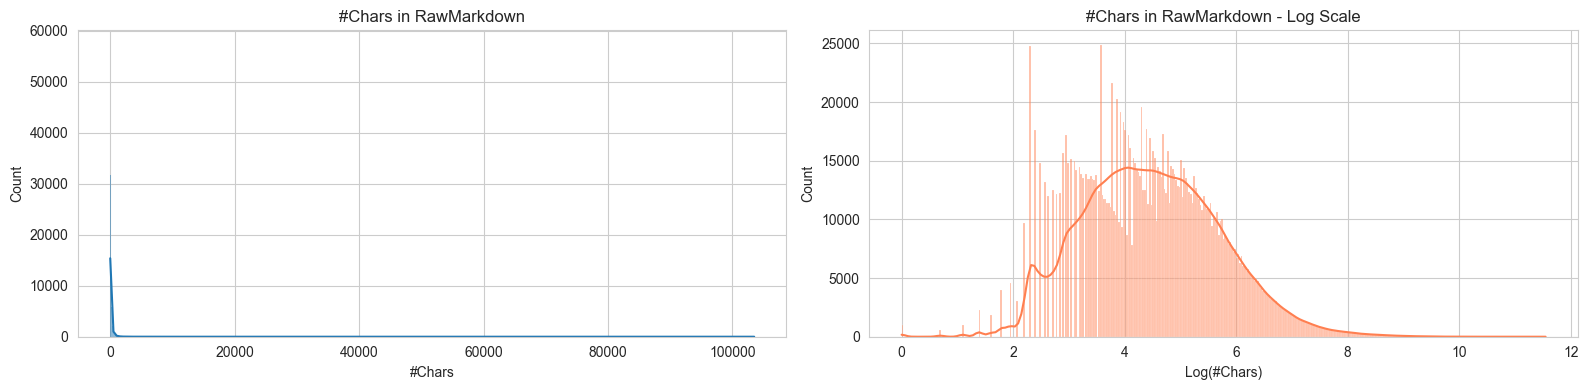

In [26]:
have_rawmd = (
    forum_msg_comp_or_kernel
    .filter(pl.col("RawMarkdown") != "")
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

ax = axes[0]
sns.histplot(have_rawmd["rawmd_len"].to_numpy(), kde=True, ax=ax)
ax.set_title("#Chars in RawMarkdown")
ax.set_xlabel("#Chars")

ax = axes[1]
sns.histplot(np.log(have_rawmd["rawmd_len"].to_numpy()), kde=True, color="coral", ax=ax)
ax.set_title("#Chars in RawMarkdown - Log Scale")
ax.set_xlabel("Log(#Chars)")

plt.tight_layout()

In [27]:
have_rawmd["rawmd_len"].min(), have_rawmd["rawmd_len"].max()

(1, 103506)

In [28]:
have_rawmd.filter(pl.col("rawmd_len") < 20)["RawMarkdown"].unique()

RawMarkdown
str
"""why is this bad"""
"""Hello Everyone."""
"""Sure @subbhashit"""
"""Support R user!"""
"""yentsai thanks!"""
…
"""you have 35 models?"""
"""Sure @arezalo"""
"""yes thank you."""


In [29]:
have_rawmd.filter(pl.col("rawmd_len") > 1e4)

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug,CurrentUrlSlug,author_name,forum_url,msg_len,rawmd_len
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str,str,str,str,u32,u32
83720,15082,2015-07-07 23:05:10,"""""","""<p>[quote=Andrey Akhmetov;837…","""[quote=Andrey Akhmetov;83708]…","""""","""""","""asimkievich""",725,null,"""congrats to the winners!""","""crowdflower-search-relevance""",null,null,"""https://www.kaggle.com/competi…",10554,10342
91231,15647,2015-09-01 17:34:29,"""""","""<p>Hi I try to run this script…","""Hi I try to run this script as…","""""","""""","""launeric""",null,11857,"""RF + XGBoost + keras + flatlin…",null,"""rf-xgboost-keras-flatline""","""domcastro""","""https://www.kaggle.com/code/do…",14910,15342
101429,17896,2015-12-15 11:02:05,"""""","""<p>So... First, I am very surp…","""So... First, I am very surpri…","""2""","""05/21/2018""","""wildwizard""",823,null,"""Share your solution""","""rossmann-store-sales""",null,null,"""https://www.kaggle.com/competi…",11906,11612
107671,18902,2016-02-11 23:46:03,"""""","""<p>I thought it might provide …","""I thought it might provide som…","""2""","""07/15/2016""","""jeffsonas""",1060,null,"""Understanding the benchmark su…","""march-machine-learning-mania-2…",null,null,"""https://www.kaggle.com/competi…",13695,13211
109700,19240,2016-02-29 16:09:52,"""""","""<p>Last edit: 23:56 GMT 01 Mar…","""Last edit: 23:56 GMT 01 March …","""1""","""07/15/2016""","""laurae2""",1042,null,"""Analysis of Duplicate Variable…","""bnp-paribas-cardif-claims-mana…",null,null,"""https://www.kaggle.com/competi…",15401,14860
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2982444,532728,2024-09-07 20:29:10,"""""","""<p>First, I would like to exte…","""First, I would like to extend …","""1""","""09/08/2024""","""uryednap""",3981237,null,"""8th Place solution (Trust your…","""isic-2024-challenge""",null,null,"""https://www.kaggle.com/competi…",14522,13145
2982793,532784,2024-09-08 08:52:42,"""""","""<h1>69th Place Solution</h1> <…","""# 69th Place Solution First o…","""2""","""09/09/2024""","""zhiyue666""",3981237,null,"""69th Place Solution""","""isic-2024-challenge""",null,null,"""https://www.kaggle.com/competi…",10447,10627
2982802,532786,2024-09-08 09:05:41,"""""","""<p>First, I would like to sinc…","""First, I would like to sincere…","""1""","""09/08/2024""","""zone0906""",3981237,null,"""14th place solution""","""isic-2024-challenge""",null,null,"""https://www.kaggle.com/competi…",12715,12694
